In [44]:
import pandas as pd
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from AttentiveFP import Fingerprint  # assumed to be your attentive FP model
from AttentiveFP import get_smiles_dicts, get_smiles_array, num_atom_features, \
    num_bond_features  # assumed to be your actual featurizer

In [45]:
# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'Irritation_Corrosion_Eye_Irritation'

# --- Dataset ---
class MoleculeDataset(Dataset):
    def __init__(self, smiles_list, targets, feature_dicts):
        self.smiles_list = smiles_list
        self.targets = targets
        self.feature_dicts = feature_dicts
        self.x_atom, self.x_bond, self.x_atom_index, self.x_bond_index, self.x_mask, _ = get_smiles_array(smiles_list, feature_dicts)

    def __len__(self):
        return len(self.feature_dicts)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.x_atom[idx], dtype=torch.float32),
            torch.tensor(self.x_bond[idx], dtype=torch.float32),
            torch.tensor(self.x_atom_index[idx], dtype=torch.long),
            torch.tensor(self.x_bond_index[idx], dtype=torch.long),
            torch.tensor(self.x_mask[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32)
        )

In [46]:
import logging
from rdkit import Chem
from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --- Load data ---
# --- Load and validate data ---
df = pd.read_csv(f"../data/{model_name}.csv")
data_path = Path(f"../data/{model_name}.csv")
smiles_list = df["smiles"].tolist()
if not data_path.exists():
    raise FileNotFoundError(f"Data file not found: {data_path}")

df = pd.read_csv(data_path)
targets = df["active"].tolist()
feature_dicts = get_smiles_dicts(smiles_list)
logger.info(f"Loaded dataset with {len(df)} samples")

# Validate SMILES and targets
valid_idx = []
valid_smiles = []
valid_targets = []

for idx, (smiles, target) in enumerate(zip(df["smiles"], df["active"])):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None and isinstance(target, (int, float)) and target in [0, 1]:
        valid_idx.append(idx)
        valid_smiles.append(smiles)
        valid_targets.append(target)
    else:
        logger.warning(f"Invalid entry at index {idx}: SMILES={smiles}, target={target}")

logger.info(f"Valid samples: {len(valid_smiles)} out of {len(df)}")

# Check class distribution
from collections import Counter
initial_distribution = Counter(valid_targets)
logger.info(f"Initial class distribution: {initial_distribution}")

# First split: 60% train, 20% val, 20% test
# First split: 60% train, 20% val, 20% test with stratification
from sklearn.model_selection import train_test_split

train_smiles, temp_smiles, train_targets, temp_targets = train_test_split(
    valid_smiles, valid_targets, test_size=0.4, random_state=42, stratify=valid_targets
)

val_smiles, test_smiles, val_targets, test_targets = train_test_split(
    temp_smiles, temp_targets, test_size=0.5, random_state=42, stratify=temp_targets
)

logger.info(f"Train samples: {len(train_smiles)}")
logger.info(f"Val samples: {len(val_smiles)}")
logger.info(f"Test samples: {len(test_smiles)}")

# Apply oversampling only to training data
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler()
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample([[s] for s in train_smiles], train_targets)
train_smiles_resampled = [x[0] for x in X_res]

print("Class distribution in original training set:", Counter(train_targets))
logger.info("Class distribution:")
logger.info(f"Original training set: {Counter(train_targets)}")
print("Class distribution after resampling:", Counter(y_res))
logger.info(f"After resampling: {Counter(y_res)}")
logger.info(f"Validation set: {Counter(val_targets)}")
logger.info(f"Test set: {Counter(test_targets)}")

# Flatten X_res to get new smiles
# Calculate class weights based on original training data
from sklearn.utils.class_weight import compute_class_weight
smiles_list_resampled = [x[0] for x in X_res]

class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_targets)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weights_dict)
logger.info(f"Class weights: {class_weights_dict}")

print(Counter(y_res))  # See new class balance
# Convert to tensor for PyTorch
pos_weight = torch.tensor([class_weights_dict[1] / class_weights_dict[0]], device=device)

# Rebuild features and dataset
# Get feature dictionaries for all sets
try:
    feature_dicts_resampled = get_smiles_dicts(smiles_list_resampled)
    dataset = MoleculeDataset(smiles_list_resampled, y_res, feature_dicts_resampled)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    feature_dicts_val = get_smiles_dicts(val_smiles)
    feature_dicts_test = get_smiles_dicts(test_smiles)
except Exception as e:
    logger.error(f"Error generating feature dictionaries: {e}")
    raise

# Create datasets
train_dataset = MoleculeDataset(train_smiles_resampled, y_res, feature_dicts_resampled)
val_dataset = MoleculeDataset(val_smiles, val_targets, feature_dicts_val)
test_dataset = MoleculeDataset(test_smiles, test_targets, feature_dicts_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



FS(F)(F)(F)(F)c1ccccc1


INFO:__main__:Loaded dataset with 5125 samples
INFO:__main__:Valid samples: 5125 out of 5125
INFO:__main__:Initial class distribution: Counter({1: 3832, 0: 1293})
INFO:__main__:Train samples: 3075
INFO:__main__:Val samples: 1025
INFO:__main__:Test samples: 1025
INFO:__main__:Class distribution:
INFO:__main__:Original training set: Counter({1: 2299, 0: 776})
INFO:__main__:After resampling: Counter({1: 2299, 0: 2299})
INFO:__main__:Validation set: Counter({1: 767, 0: 258})
INFO:__main__:Test set: Counter({1: 766, 0: 259})
INFO:__main__:Class weights: {0: 1.9813144329896908, 1: 0.6687690300130491}


Class distribution in original training set: Counter({1: 2299, 0: 776})
Class distribution after resampling: Counter({1: 2299, 0: 2299})
Class weights: {0: 1.9813144329896908, 1: 0.6687690300130491}
Counter({1: 2299, 0: 2299})
FS(F)(F)(F)(F)c1ccccc1


In [47]:
# --- Model ---
model = Fingerprint(
    radius=5,
    T=3,  # Increased T for better message passing
    input_feature_dim=num_atom_features(),
    input_bond_dim=num_bond_features(),
    fingerprint_dim=150,  # Increased dimension for more complex feature learning
    output_units_num=1,
    p_dropout=0.3  # Increased dropout for better regularization
).to(device)

# Using a lower learning rate and higher weight decay for better generalization
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Calculate class weights based on the original class distribution
# Use weighted loss function
loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight)


In [48]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import os

def init_early_stopping(patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    return best_val_loss, patience_counter, best_model_state

# Add before training loop
best_val_loss, patience_counter, best_model_state = init_early_stopping(patience=5)


def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for atom, bond, atom_deg, bond_deg, mask, target in loader:
            atom, bond, atom_deg, bond_deg, mask, target = [
                t.to(device) for t in (atom, bond, atom_deg, bond_deg, mask, target)
            ]
            _, pred, _ = model(atom, bond, atom_deg, bond_deg, mask)
            pred = pred.view(-1)
            target = target.view(-1).float()

            loss = loss_fn(pred, target)
            total_loss += loss.item()

            prob = torch.sigmoid(pred).cpu().numpy()
            all_probs.extend(prob)
            all_preds.extend((prob > 0.5).astype(int))
            all_targets.extend(target.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except:
        auc = 0.0
    return total_loss, acc, f1, auc

# Folder to save model
os.makedirs("../models", exist_ok=True)
best_loss = float("inf")
path = f"../models/model_{model_name}.pt"

for epoch in range(30):
    model.train()
    train_loss = 0

    for batch in train_loader:
        atom, bond, atom_deg, bond_deg, mask, target = [
            t.to(device) for t in batch
        ]
        optimizer.zero_grad()
        _, pred, _ = model(atom, bond, atom_deg, bond_deg, mask)
        loss = loss_fn(pred.squeeze(), target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
        optimizer.step()
        train_loss += loss.item()

    val_loss, val_acc, val_f1, val_auc = evaluate(val_loader)
    scheduler.step(val_loss)  # Update learning rate based on validation loss

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} "
          f"- Val Acc: {val_acc:.3f} - Val F1: {val_f1:.3f} - Val AUC: {val_auc:.3f} "
          f"- LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        torch.save(model.state_dict(), path)
        print(f"✅ Saved best model (val loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= 5:  # Early stopping patience
            print("Early stopping triggered!")
            break



Epoch 1 - Train Loss: 0.2997 - Val Loss: 0.3534 - Val Acc: 0.333 - Val F1: 0.000 - Val AUC: 1.000 - LR: 0.001000
✅ Saved best model (val loss: 0.3534)
Epoch 2 - Train Loss: 0.2739 - Val Loss: 0.3252 - Val Acc: 0.333 - Val F1: 0.000 - Val AUC: 1.000 - LR: 0.001000
✅ Saved best model (val loss: 0.3252)
Epoch 3 - Train Loss: 0.2524 - Val Loss: 0.2938 - Val Acc: 0.333 - Val F1: 0.000 - Val AUC: 1.000 - LR: 0.001000
✅ Saved best model (val loss: 0.2938)
Epoch 4 - Train Loss: 0.2373 - Val Loss: 0.2735 - Val Acc: 0.500 - Val F1: 0.400 - Val AUC: 1.000 - LR: 0.001000
✅ Saved best model (val loss: 0.2735)
Epoch 5 - Train Loss: 0.2278 - Val Loss: 0.2631 - Val Acc: 0.833 - Val F1: 0.857 - Val AUC: 1.000 - LR: 0.001000
✅ Saved best model (val loss: 0.2631)
Epoch 6 - Train Loss: 0.2204 - Val Loss: 0.2601 - Val Acc: 1.000 - Val F1: 1.000 - Val AUC: 1.000 - LR: 0.001000
✅ Saved best model (val loss: 0.2601)
Epoch 7 - Train Loss: 0.2007 - Val Loss: 0.2576 - Val Acc: 1.000 - Val F1: 1.000 - Val AUC: 1.

In [49]:
# Load best model
model.load_state_dict(torch.load(path))
model.to(device)

test_loss, test_acc, test_f1, test_auc = evaluate(test_loader)
print(f"🧪 Test Loss: {test_loss:.4f} - Acc: {test_acc:.3f} - F1: {test_f1:.3f} - AUC: {test_auc:.3f}")

🧪 Test Loss: 0.1722 - Acc: 1.000 - F1: 1.000 - AUC: 0.000


/home/alex-arvanitidis-ntua/Projects/ntua/pyrosage/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


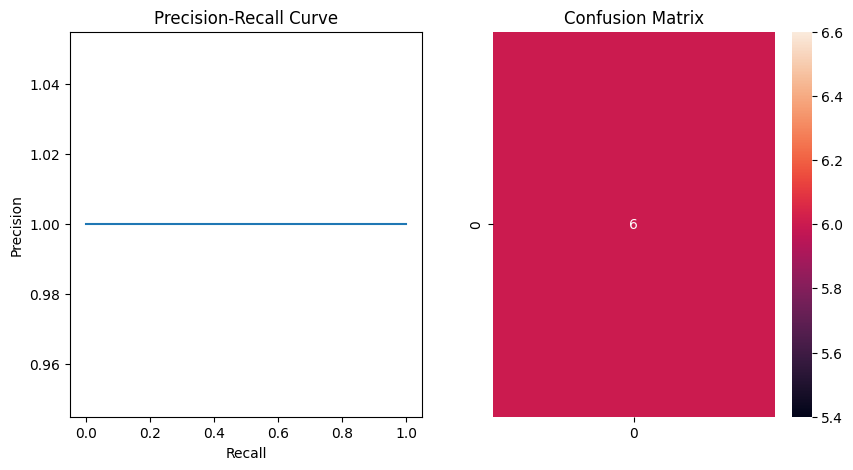

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import precision_recall_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            atom, bond, atom_deg, bond_deg, mask, target = [
                t.to(device) for t in batch
            ]
            _, pred, _ = model(atom, bond, atom_deg, bond_deg, mask)
            prob = torch.sigmoid(pred).cpu().numpy()
            all_preds.extend(prob)
            all_targets.extend(target.cpu().numpy())

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(all_targets, all_preds)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    # Confusion Matrix
    cm = confusion_matrix(all_targets, (np.array(all_preds) > 0.5).astype(int))
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.show()

# Call after training
plot_training_metrics(model, test_loader)